In [1]:
from pymongo import MongoClient
import json
from bson import json_util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
import nltk
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import gzip
from pandas.io.json import json_normalize
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from nltk.stem import PorterStemmer

### Data Preparation

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta = getDF('meta_Electronics.json.gz')

In [3]:
meta.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [4]:
meta.dropna(subset=['brand'], inplace = True)

In [5]:
meta.isna().sum()/len(meta)

asin           0.000000
imUrl          0.000000
description    0.037725
categories     0.000000
title          0.000007
price          0.011899
salesRank      0.674978
related        0.090808
brand          0.000000
dtype: float64

In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142532 entries, 6 to 498195
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asin         142532 non-null  object 
 1   imUrl        142532 non-null  object 
 2   description  137155 non-null  object 
 3   categories   142532 non-null  object 
 4   title        142531 non-null  object 
 5   price        140836 non-null  float64
 6   salesRank    46326 non-null   object 
 7   related      129589 non-null  object 
 8   brand        142532 non-null  object 
dtypes: float64(1), object(8)
memory usage: 10.9+ MB


In [7]:
client = MongoClient('localhost', 27017) 

db = client.nguyen83 # replace YourMUID is your MUID

db.authenticate('nguyen83','farmerai','ISA414')

# create tweets collection
electronics = db.electronics

In [8]:
mongo_data = electronics.find({}) # find all reviews

# load MongoDB data as JSON data and flatten using json_normalize
sanitized = json.loads(json_util.dumps(mongo_data))
normalized = json_normalize(sanitized)

# create data frame containing four columns and remove duplicates
reviews = pd.DataFrame(normalized, columns=['asin', 'helpful', 'reviewText', 'overall'])
reviews.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,asin,helpful,reviewText,overall
0,0132793040,"[1, 1]",Corey Barker does a great job of explaining Bl...,5
1,0321732944,"[0, 0]",While many beginner DVDs try to teach you ever...,5
2,0439886341,"[1, 1]",It never worked. My daughter worked to earn th...,1
3,0439886341,"[1, 1]",Some of the functions did not work properly. ...,3
4,0439886341,"[4, 4]",Do not waste your money on this thing it is te...,1


In [9]:
# The brands with more than 1000 reviews are saved to this csv file
# cond = merge_df['brand'].value_counts() > 1000
# subjects = list(cond[cond == True].index)

brands = pd.read_csv("brands.csv")
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       501 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB


In [10]:
meta = meta[meta['brand'].isin(brands["0"])][['asin', 'price', 'brand']]
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86468 entries, 6 to 498195
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   asin    86468 non-null  object 
 1   price   85316 non-null  float64
 2   brand   86468 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.6+ MB


In [11]:
merge_df = reviews.merge(meta, on="asin")
merge_df.isna().sum()/len(merge_df)

asin          0.00000
helpful       0.00000
reviewText    0.00000
overall       0.00000
price         0.00943
brand         0.00000
dtype: float64

In [12]:
#Data Cleaning and Imputation

merge_df.dropna(subset=['brand'], inplace=True)
merge_df['helpful'] = merge_df['helpful'].astype(str)
ls = merge_df['helpful'].apply(lambda x: x.split(","))
merge_df['helpful_no']  = ls.apply(lambda x : x[0].strip('['))
merge_df['helpful_yes'] = ls.apply(lambda x : x[1].strip(']').strip(' '))
merge_df[['helpful_no', 'helpful_yes']] = merge_df[['helpful_no', 'helpful_yes']].astype(int)
merge_df['target'] = merge_df['overall'].map({1: 0, 2: 0, 3: 0, 4: 1,5: 1})
merge_df['reviewText']= merge_df['reviewText'].apply(lambda x: x.lower())
merge_df['price_cleaned'] = merge_df.groupby("brand")['price'].transform(lambda x: x.fillna(x.mean()))

In [13]:
merge_df.head()

,asin,helpful,reviewText,overall,price,brand,helpful_no,helpful_yes,target,price_cleaned
0,059400232X,"[0, 0]","this cover fits very nice, and looks like rich...",5,4.99,Barnes &amp; Noble,0,0,1,4.99
1,059400232X,"[1, 2]",i bought this for my daughter. i'm the writer ...,5,4.99,Barnes &amp; Noble,1,2,1,4.99
2,059400232X,"[0, 0]",very happy.with.my nook cover. i want one wit...,5,4.99,Barnes &amp; Noble,0,0,1,4.99
3,0594012015,"[0, 0]","didn't work, had to send back",1,32.10,Barnes &amp; Noble,0,0,0,32.10
4,0594012015,"[0, 0]",just what i needed!,5,32.10,Barnes &amp; Noble,0,0,1,32.10


In [14]:
merge_df.isna().sum()/len(merge_df)

asin             0.00000
helpful          0.00000
reviewText       0.00000
overall          0.00000
price            0.00943
brand            0.00000
helpful_no       0.00000
helpful_yes      0.00000
target           0.00000
price_cleaned    0.00000
dtype: float64

In [15]:
merge_df.head()

,asin,helpful,reviewText,overall,price,brand,helpful_no,helpful_yes,target,price_cleaned
0,059400232X,"[0, 0]","this cover fits very nice, and looks like rich...",5,4.99,Barnes &amp; Noble,0,0,1,4.99
1,059400232X,"[1, 2]",i bought this for my daughter. i'm the writer ...,5,4.99,Barnes &amp; Noble,1,2,1,4.99
2,059400232X,"[0, 0]",very happy.with.my nook cover. i want one wit...,5,4.99,Barnes &amp; Noble,0,0,1,4.99
3,0594012015,"[0, 0]","didn't work, had to send back",1,32.10,Barnes &amp; Noble,0,0,0,32.10
4,0594012015,"[0, 0]",just what i needed!,5,32.10,Barnes &amp; Noble,0,0,1,32.10


In [16]:
eda = merge_df.copy(deep=True)

In [17]:
merge_df.drop(["helpful", "overall", "price"], axis = 1, inplace = True)

In [18]:
reddit = pd.read_csv("pushshift_clean_vader.csv")
reddit.head()

,Unnamed: 0,Unnamed: 0.1,brand,selftext_clean,title_clean,alltext_clean,selftext_pos,selftext_neg,selftext_neu,selftext_com,title_pos,title_neg,title_neu,title_com,alltext_pos,alltext_neg,alltext_neu,alltext_com
0,0,0,Barnes &amp; Noble,NaN,user profil barn amp nobl,user profil barn amp nobl,0.0,0.0,1.0,0.0,0.0,0.000,1.000,0.0000,0.0,0.000,1.000,0.0000
1,1,1,Barnes &amp; Noble,NaN,mywishlist barbara carr barn amp nobl,mywishlist barbara carr barn amp nobl,0.0,0.0,1.0,0.0,0.0,0.000,1.000,0.0000,0.0,0.000,1.000,0.0000
2,2,2,Barnes &amp; Noble,NaN,rowenacherri librari barn amp nobl,rowenacherri librari barn amp nobl,0.0,0.0,1.0,0.0,0.0,0.000,1.000,0.0000,0.0,0.000,1.000,0.0000
3,3,3,Barnes &amp; Noble,delet,coffe barn amp nobl discov charg wifi thru amp...,delet coffe barn amp nobl discov charg wifi th...,0.0,0.0,1.0,0.0,0.0,0.091,0.909,-0.3182,0.0,0.087,0.913,-0.3182
4,4,4,Barnes &amp; Noble,delet,coffe barn amp nobl discov charg wifi thru amp...,delet coffe barn amp nobl discov charg wifi th...,0.0,0.0,1.0,0.0,0.0,0.091,0.909,-0.3182,0.0,0.087,0.913,-0.3182


In [19]:
reddit_selected = reddit.groupby("brand")[['title_com', 'alltext_com']].mean()
reddit_selected.reset_index(inplace=True)
reddit_selected.head()

,brand,title_com,alltext_com
0,3M,-0.029378,-0.029378
1,ADATA,0.079768,0.420384
2,AGPtek,0.102721,0.333586
3,AKG,0.133016,0.304494
4,AMD,-0.031580,-0.031580


In [20]:
merge_df = merge_df.merge(reddit_selected, on="brand")
merge_df.isna().sum()/len(merge_df)

asin             0.0
reviewText       0.0
brand            0.0
helpful_no       0.0
helpful_yes      0.0
target           0.0
price_cleaned    0.0
title_com        0.0
alltext_com      0.0
dtype: float64

In [21]:
merge_df.drop(['asin'], axis = 1, inplace = True)

In [22]:
# merge_df.to_csv("cleaned_data.csv")

In [23]:
merge_df.head()

,reviewText,brand,helpful_no,helpful_yes,target,price_cleaned,title_com,alltext_com
0,"this cover fits very nice, and looks like rich...",Barnes &amp; Noble,0,0,1,4.99,0.013594,0.013594
1,i bought this for my daughter. i'm the writer ...,Barnes &amp; Noble,1,2,1,4.99,0.013594,0.013594
2,very happy.with.my nook cover. i want one wit...,Barnes &amp; Noble,0,0,1,4.99,0.013594,0.013594
3,"didn't work, had to send back",Barnes &amp; Noble,0,0,0,32.10,0.013594,0.013594
4,just what i needed!,Barnes &amp; Noble,0,0,1,32.10,0.013594,0.013594


### Explanatory Data Analysis

In [24]:
from pandas_profiling import ProfileReport
profile = ProfileReport(eda, title="Pandas Profiling Report")
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
target_counts = merge_df.target.value_counts()
type(target_counts)

pandas.core.series.Series

In [26]:
merge_df.target = merge_df.target.astype(str)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3038135 entries, 0 to 3038134
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   reviewText     object 
 1   brand          object 
 2   helpful_no     int64  
 3   helpful_yes    int64  
 4   target         object 
 5   price_cleaned  float64
 6   title_com      float64
 7   alltext_com    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 208.6+ MB


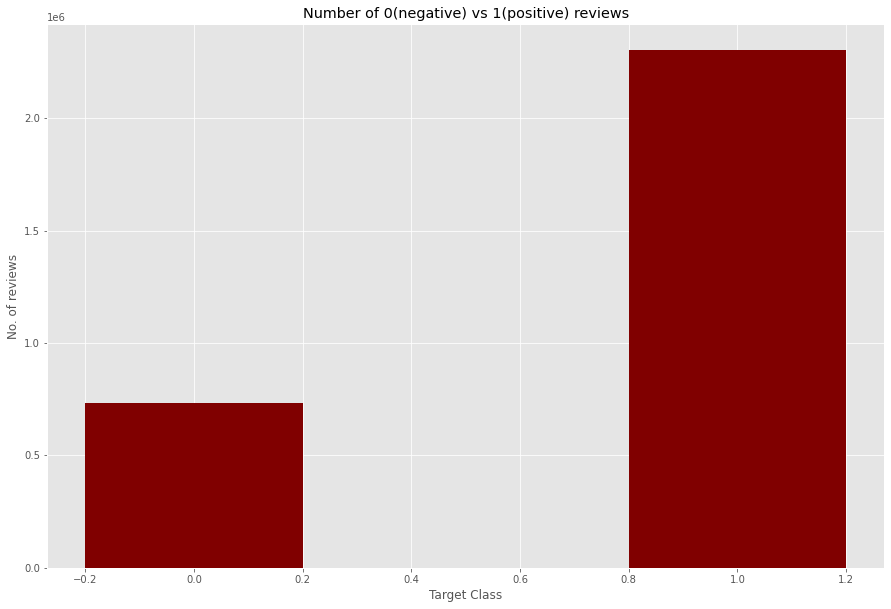

In [27]:

fig = plt.figure(figsize = (15, 10))
 
# creating the bar plot
plt.bar(x=target_counts.index, height=target_counts.values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Target Class")
plt.ylabel("No. of reviews")
plt.title("Number of 0(negative) vs 1(positive) reviews")
plt.savefig("Class_Imbalance.jpg")
plt.show()

In [30]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3038135 entries, 0 to 3038134
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   reviewText     object 
 1   brand          object 
 2   helpful_no     int64  
 3   helpful_yes    int64  
 4   target         object 
 5   price_cleaned  float64
 6   title_com      float64
 7   alltext_com    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 208.6+ MB
